In [1]:
import h5py
import os
import cPickle as pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
import collections
import Queue
from collections import Counter

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
(image_metadata, book_metadata, image_to_idx) = pickle.load(open("/data/all_metadata_1M_tags.pkl", 'r'))
image_hdf5 = h5py.File('/data/image_data.hdf5','r')

In [3]:
ocr_hdf5 = h5py.File('/data/ocr_data.hdf5','r')

## Set up natural language processing

In [4]:
# coding=UTF-8
import nltk
from nltk.corpus import brown

# This is a fast and simple noun phrase extractor (based on NLTK)
# Feel free to use it, just keep a link back to this post
# http://thetokenizer.com/2013/05/09/efficient-way-to-extract-the-main-topics-of-a-sentence/
# Create by Shlomi Babluki
# May, 2013

# This is our fast Part of Speech tagger
#############################################################################
brown_train = brown.tagged_sents(categories='news')
regexp_tagger = nltk.RegexpTagger(
    [(r'^-?[0-9]+(.[0-9]+)?$', 'CD'),
     (r'(-|:|;)$', ':'),
     (r'\'*$', 'MD'),
     (r'(The|the|A|a|An|an)$', 'AT'),
     (r'.*able$', 'JJ'),
     (r'^[A-Z].*$', 'NNP'),
     (r'.*ness$', 'NN'),
     (r'.*ly$', 'RB'),
     (r'.*s$', 'NNS'),
     (r'.*ing$', 'VBG'),
     (r'.*ed$', 'VBD'),
     (r'.*', 'NN')
])
unigram_tagger = nltk.UnigramTagger(brown_train, backoff=regexp_tagger)
bigram_tagger = nltk.BigramTagger(brown_train, backoff=unigram_tagger)
#############################################################################


# This is our semi-CFG; Extend it according to your own needs
#############################################################################
cfg = {}
cfg["NNP+NNP"] = "NNP"
cfg["NN+NN"] = "NNI"
cfg["NNI+NN"] = "NNI"
cfg["JJ+JJ"] = "JJ"
cfg["JJ+NN"] = "NNI"
#############################################################################


class NPExtractor(object):

    def __init__(self, sentence):
        self.sentence = sentence

    # Split the sentence into singlw words/tokens
    def tokenize_sentence(self, sentence):
        tokens = nltk.word_tokenize(sentence)
        return tokens

    # Normalize brown corpus' tags ("NN", "NN-PL", "NNS" > "NN")
    def normalize_tags(self, tagged):
        n_tagged = []
        for t in tagged:
            if t[1] == "NP-TL" or t[1] == "NP":
                n_tagged.append((t[0], "NNP"))
                continue
            if t[1].endswith("-TL"):
                n_tagged.append((t[0], t[1][:-3]))
                continue
            if t[1].endswith("S"):
                n_tagged.append((t[0], t[1][:-1]))
                continue
            n_tagged.append((t[0], t[1]))
        return n_tagged

    # Extract the main topics from the sentence
    def extract(self):

        tokens = self.tokenize_sentence(self.sentence)
        tags = self.normalize_tags(bigram_tagger.tag(tokens))

        merge = True
        while merge:
            merge = False
            for x in range(0, len(tags) - 1):
                t1 = tags[x]
                t2 = tags[x + 1]
                key = "%s+%s" % (t1[1], t2[1])
                value = cfg.get(key, '')
                if value:
                    merge = True
                    tags.pop(x)
                    tags.pop(x)
                    match = "%s %s" % (t1[0], t2[0])
                    pos = value
                    tags.insert(x, (match, pos))
                    break

        matches = []
        for t in tags:
            if t[1] == "NNP" or t[1] == "NNI":
            #if t[1] == "NNP" or t[1] == "NNI" or t[1] == "NN":
                matches.append(t[0])
        return matches

## Do TF-IDF

we are sampling 10K images

In [5]:
def get_noun_phrases_from_img(chunk, img):
    chunk = int(chunk)
    img = int(img)
    
    phrase = ' '.join(ocr_hdf5['Chunk{}'.format(chunk)][img][1:]).decode("ascii", errors="ignore")
    np_extractor = NPExtractor(phrase)
    multiword_res = [x.lower() for x in np_extractor.extract()]
    
    res = []
    for word in multiword_res:
        res.extend(word.split(' '))
        
    # number of items in the set divided by total length; a marker of English or not-English
    pct_np = float(len(set(res)))/len(phrase)
    
    # get the words that appear most often
    #print Counter(res).most_common(10)

    return pct_np, res

def get_noun_phrases_from_text(txt):
    np_extractor = NPExtractor(txt)
    multiword_res = [x.lower() for x in np_extractor.extract()]
    
    res = []
    for word in multiword_res:
        res.extend(word.split(' '))
    
    res = [x for x in res if len(x) > 3]
    return res

In [6]:
sampled_images = []
sampled_text = []
for_lang = ['avec', 'sich', 'eine', 'nach', 'auch', 'nicht', 'wurde', 'alle']
for chunk in range(200):
    if chunk % 50 == 0: 
        print(chunk)
    for index in np.random.choice(range(5000), 50):
        try:
            ocr = ' '.join(ocr_hdf5['Chunk{}'.format(chunk)][index][1:]).decode("ascii", errors="ignore")
            if ocr == '   ': continue
            if any(word in ocr for word in for_lang): continue
#             pct, words = get_noun_phrases_from_img(chunk, index)
#             if pct > 0.03: continue
            sampled_images.append((chunk, index))
            sampled_text.append(ocr)
        except:
            pass
    
np.random.shuffle(sampled_text)

0
50
100
150


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.05, stop_words='english',
                                 use_idf=True, tokenizer=get_noun_phrases_from_text, ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(sampled_text[:1000]) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 43.9 s, sys: 14.6 ms, total: 43.9 s
Wall time: 43.9 s
(1000, 82)


In [9]:
terms = tfidf_vectorizer.get_feature_names()
terms

[u'ancient',
 u'beautiful',
 u'black',
 u'certain',
 u'chapter',
 u'charles',
 u'chief',
 u'church',
 u'city',
 u'country',
 u'dear',
 u'different',
 u'early',
 u'english',
 u'eyes',
 u'fair',
 u'family',
 u'father',
 u'fine',
 u'form',
 u'general',
 u'george',
 u'good',
 u'grand',
 u'great',
 u'green',
 u'hand',
 u'heart',
 u'henry',
 u'high',
 u'home',
 u'house',
 u'human',
 u'james',
 u'john',
 u'king',
 u'lady',
 u'land',
 u'large',
 u'late',
 u'life',
 u'light',
 u'london',
 u'long',
 u'lord',
 u'morning',
 u'mrs.',
 u'noble',
 u'numerous',
 u'open',
 u'people',
 u'place',
 u'poor',
 u'present',
 u'public',
 u'right',
 u'river',
 u'round',
 u'royal',
 u'short',
 u'small',
 u'square',
 u'state',
 u'stone',
 u'street',
 u'sweet',
 u'thomas',
 u'thou',
 u'till',
 u'time',
 u'tion',
 u'town',
 u'various',
 u'water',
 u'western',
 u'white',
 u'william',
 u'woman',
 u'work',
 u'world',
 u'years',
 u'young']

In [16]:
tfidf_matrix.

array([70, 62, 33, ..., 48, 83, 81], dtype=int32)

## K-means

In [10]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 364 ms, sys: 3.98 ms, total: 368 ms
Wall time: 367 ms


In [15]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km, '/data/ocr_clustering/doc_cluster.pkl')

km = joblib.load('/data/ocr_clustering/doc_cluster.pkl')
clusters = km.labels_.tolist()

In [11]:
from __future__ import print_function

terms = tfidf_vectorizer.get_feature_names()
print("Top terms per cluster:")
print()

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % terms[ind], end=',')
    print() #add whitespace
    print("Number of images: {}".format(clusters.count(i)))
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: great, large, small, river, tion, western,
Number of images: 199

Cluster 1 words: john, street, lord, general, william, charles,
Number of images: 145

Cluster 2 words: good, thou, poor, long, young, heart,
Number of images: 185

Cluster 3 words: till, chapter, grand, king, land, woman,
Number of images: 415

Cluster 4 words: mrs., lady, young, dear, chapter, good,
Number of images: 56





## PCA

In [43]:
import sklearn
tsne = sklearn.manifold.TSNE(2)
tfidf_matrix_pca = tsne.fit_transform(tfidf_matrix.toarray())

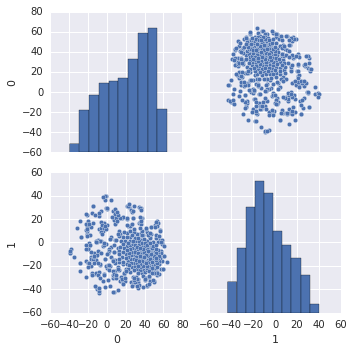

In [44]:
sns.pairplot(pd.DataFrame(tfidf_matrix_pca))

## Hierarchical

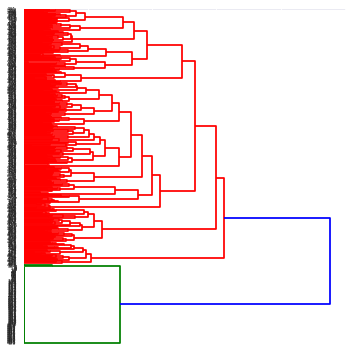

In [42]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(5,5)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## Latent Dirichlet Association

In [12]:
from gensim import corpora, models, similarities 

In [13]:
stopwords = nltk.corpus.stopwords.words('english')
%time tokenized_text = [get_noun_phrases_from_text(text) for text in sampled_text[:1000]]
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]    

CPU times: user 38.5 s, sys: 8.63 ms, total: 38.5 s
Wall time: 38.4 s
CPU times: user 308 ms, sys: 16.4 ms, total: 324 ms
Wall time: 300 ms


In [9]:
%time a = [get_noun_phrases_from_text(text) for text in sampled_text[:1000]]

CPU times: user 32.9 s, sys: 0 ns, total: 32.9 s
Wall time: 32.9 s


In [14]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=0.05, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [15]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=500, passes=20)

CPU times: user 1min 8s, sys: 17 ms, total: 1min 8s
Wall time: 1min 8s


In [16]:
lda.show_topics()

[(0,
  u'0.004*till + 0.003*john + 0.001*thomas + 0.001*hans + 0.001*seat + 0.001*gustaf + 0.001*fven + 0.001*hade + 0.001*large + 0.001*james'),
 (1,
  u'0.002*para + 0.002*great + 0.002*london + 0.002*large + 0.002*illustrations + 0.002*part + 0.001*small + 0.001*ship + 0.001*crown + 0.001*good'),
 (2,
  u'0.002*hogy + 0.001*volt + 0.001*mint + 0.001*dans + 0.001*lead + 0.001*bill + 0.001*cloth + 0.001*buffalo + 0.001*coal + 0.001*para'),
 (3,
  u'0.003*great + 0.003*good + 0.003*miss + 0.003*john + 0.003*mrs. + 0.002*young + 0.002*life + 0.002*london + 0.002*english + 0.002*large'),
 (4,
  u'0.004*great + 0.003*john + 0.002*thou + 0.002*large + 0.002*mrs. + 0.002*long + 0.002*small + 0.002*london + 0.002*chapter + 0.002*good')]

In [17]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

for i in topics_matrix:
    print([str(word[0]) for word in i[1]][:5])
    print()

['till', 'john', 'thomas', 'hans', 'seat']

['para', 'great', 'london', 'large', 'illustrations']

['hogy', 'volt', 'mint', 'dans', 'lead']

['great', 'good', 'miss', 'john', 'mrs.']

['great', 'john', 'thou', 'large', 'mrs.']

